# setup

In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "MIG-b5356651-0d8e-5cd1-bdf3-ccbb8b221031"

import tensorflow as tf
from tensorflow import keras
import keras_tuner as kt
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import tuning_fun as tu
import emulator_fun as ef
import numpy as np
from tqdm.keras import TqdmCallback
import pandas as pd
import time

gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        print(e)

# if gpus:
#     try:
#         tf.config.experimental.set_virtual_device_configuration(
#             gpus[0],
#             [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=10240)]  # in MB
#         )
#     except RuntimeError as e:
#         print(e)

2025-04-27 03:59:40.300797: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-04-27 03:59:40.311464: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1745740780.323403 3103055 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1745740780.327070 3103055 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-04-27 03:59:40.340556: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instr

# HP tuning

## pre-processing

In [2]:
# time.sleep(600)

case_name = 'fullmic'
base_path = '/home/arthurhu/BOSS_PPE/PPE csv/'
ppe_params_fn = case_name + '_Psed_ppe_params.csv'
ppe_sim_fn = case_name + '_Psed_LWP1234_ppe_var.csv'
target_var_fn = case_name + '_LWP1234_target_var.csv'

param_all_idx = np.arange(40)
# REVIEW: check every time if this is true ... not sure how to implement this programatically
# param_interest_idx = np.arange(16,28)
param_interest_idx = np.arange(28,40)
# param_interest_idx = np.arange(0,28)
# param_interest_idx = np.arange(12)
# param_interest_idx = np.concatenate((np.arange(0,8), np.arange(16,28)))
param_not_int_idx = [i for i in param_all_idx if i not in param_interest_idx]

param_train = ef.get_params(base_path, ppe_params_fn, param_interest_idx)
# param_valid = ef.get_params(base_path, ppe_params_valid_fn, param_interest_idx)

# slim down the output sets
# output_slim = np.concatenate(([0],np.arange(1,62,4)), dtype=int)
output_slim = []
ppe_sim_train = ef.get_vars(base_path, ppe_sim_fn, slim_down=output_slim)
ppe_sim_train['vals'][np.isinf(ppe_sim_train['log_vals'])] = np.nan
# ppe_sim_train['log_vals'][np.isinf(ppe_sim_train['log_vals'])] = np.nan
# ppe_sim_valid = ef.get_vars(base_path, ppe_sim_valid_fn, slim_down=output_slim)
tgt_sim = ef.get_vars(base_path, target_var_fn)

nobs = ppe_sim_train['vals'].shape[1]
npar = param_train['vals'].shape[1]

/home/arthurhu/BOSS_PPE/emulator_fun.py:22: RuntimeWarning: divide by zero encountered in log10
  var_vals_log = np.log10(var_vals)
/home/arthurhu/BOSS_PPE/emulator_fun.py:22: RuntimeWarning: invalid value encountered in log10
  var_vals_log = np.log10(var_vals)
/home/arthurhu/BOSS_PPE/emulator_fun.py:22: RuntimeWarning: divide by zero encountered in log10
  var_vals_log = np.log10(var_vals)
/home/arthurhu/BOSS_PPE/emulator_fun.py:22: RuntimeWarning: invalid value encountered in log10
  var_vals_log = np.log10(var_vals)


In [3]:
# eff0 = np.array([1000, 1e-27, 1e-42])
# eff0 = np.array([1e-12, 100, 1e-27, 1e-42])
eff0 = np.array([1e-8, 1e-12, 100, 1e-27, 1e-42])

In [4]:
np.nanmean(tgt_sim['vals'][:,65:3665])/np.nanmean(ppe_sim_train['vals'][:,65:3665])

69.64647657131691

(array([6.235573e+06, 1.234843e+06, 6.201380e+05, 7.553210e+05,
        5.214150e+05, 4.769610e+05, 6.122990e+05, 4.057090e+05,
        5.426840e+05, 5.002690e+05, 3.343560e+05, 4.498910e+05,
        4.218980e+05, 3.933940e+05, 2.635690e+05, 3.218300e+05,
        3.288370e+05, 3.058110e+05, 2.025430e+05, 2.756810e+05,
        2.554980e+05, 2.239330e+05, 1.767630e+05, 2.150110e+05,
        1.958770e+05, 1.344670e+05, 1.739720e+05, 1.580790e+05,
        1.116720e+05, 1.378000e+05, 1.276120e+05, 9.685700e+04,
        9.463600e+04, 9.077900e+04, 7.051200e+04, 5.833200e+04,
        5.571400e+04, 4.639200e+04, 2.003100e+04, 1.082200e+04,
        7.306000e+03, 6.891000e+03, 6.297000e+03, 5.324000e+03,
        6.162000e+03, 4.229000e+03, 3.497000e+03, 4.034000e+03,
        3.293000e+03, 3.321000e+03, 3.092000e+03, 2.455000e+03,
        2.549000e+03, 2.513000e+03, 2.311000e+03, 2.205000e+03,
        1.916000e+03, 1.524000e+03, 1.639000e+03, 1.752000e+03,
        1.484000e+03, 1.312000e+03, 1.17

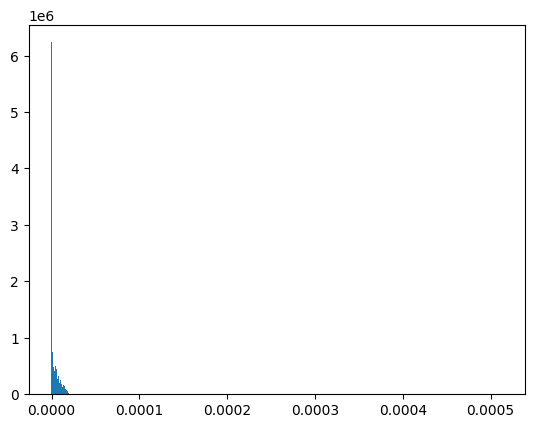

In [5]:
plt.hist(ppe_sim_train['vals'][:,65:3665].flatten(), bins=1000)

In [6]:
from sklearn import preprocessing
import sklearn.model_selection as mod_sec

minmaxscale = preprocessing.MinMaxScaler().fit(param_train['vals'])
x_all = minmaxscale.transform(param_train['vals'])
# x_val = minmaxscale.transform(param_valid['vals'])

# y_threshold = 1e-9
y_thresholds = np.zeros(ppe_sim_train['vals'].shape[1])
# y_thresholds[0]

# y_thresholds[0] = eff0[0]
# y_thresholds[1] = eff0[1]
# y_thresholds[2] = eff0[2]
# y_thresholds[3] = eff0[3]
# # y_thresholds[4:64] = 1e-5
# y_thresholds[4:3604] = eff0[0]
# y_thresholds[3604:7204] = eff0[1]
# y_thresholds[7204:10804] = eff0[2]
# y_thresholds[10804:] = eff0[3]

y_thresholds[0] = eff0[0]
y_thresholds[1] = eff0[1]
y_thresholds[2] = eff0[2]
y_thresholds[3] = eff0[3]
y_thresholds[4] = eff0[4]
y_thresholds[5:65] = eff0[0]
y_thresholds[65:3665] = eff0[1]
y_thresholds[3665:7265] = eff0[2]
y_thresholds[7265:10865] = eff0[3]
y_thresholds[10865:] = eff0[4]

# standscale = preprocessing.StandardScaler().fit(ppe_sim_train['vals'])
y_all_wpresence = (ppe_sim_train['vals'] > y_thresholds).astype('float32')

# y_log = ppe_sim_train['log_vals']
# y_log[~np.isfinite(y_log)] = np.nan
# y_log[ppe_sim_train['vals'] < y_thresholds] = np.nan
# standscale = preprocessing.StandardScaler().fit(y_log)
# y_all = standscale.transform(y_log)

# y_lin = ppe_sim_train['vals']
# y_lin[~np.isfinite(y_lin)] = np.nan
# y_lin[ppe_sim_train['vals'] < y_thresholds] = np.nan
# standscale = preprocessing.StandardScaler().fit(y_lin)
# y_all = standscale.transform(y_lin)
# y_val = np.ma.masked_invalid(standscale.transform(ppe_sim_valid['log_vals']))

y_lin = ppe_sim_train['vals']
y_lin[ppe_sim_train['vals'] < y_thresholds] = np.nan
y_lin[~np.isfinite(y_lin)] = np.nan
y_asinh = ef.smooth_linlog(y_lin, y_thresholds)
standscale = preprocessing.StandardScaler().fit(y_asinh)
y_all = standscale.transform(y_asinh)

tgt_lin = tgt_sim['vals'][:,2:]
tgt_lin[tgt_sim['vals'][:,2:] < y_thresholds] = np.nan
tgt_lin[~np.isfinite(tgt_lin)] = np.nan
tgt_asinh = ef.smooth_linlog(tgt_lin, y_thresholds)
tgt_all = standscale.transform(tgt_asinh)


x_train, x_val, y_train_wpresence, y_val_wpresence = mod_sec.train_test_split(x_all, y_all_wpresence, test_size=0.2, random_state=1)
_, _, y_train, y_val = mod_sec.train_test_split(x_all, y_all, test_size=0.2, random_state=1)

y_train = np.nan_to_num(y_train, nan=-1001)
y_val = np.nan_to_num(y_val, nan=-1001)

/home/arthurhu/BOSS_PPE/.venv/lib/python3.10/site-packages/sklearn/utils/extmath.py:1101: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
/home/arthurhu/BOSS_PPE/.venv/lib/python3.10/site-packages/sklearn/utils/extmath.py:1106: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
/home/arthurhu/BOSS_PPE/.venv/lib/python3.10/site-packages/sklearn/utils/extmath.py:1126: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count


(array([1.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 3.000e+00, 0.000e+00, 0.000e+00, 2.000e+00, 1.000e+00,
        2.000e+00, 0.000e+00, 2.000e+00, 1.000e+00, 1.000e+00, 2.000e+00,
        1.000e+00, 1.000e+00, 3.000e+00, 2.400e+01, 1.700e+01, 5.000e+00,
        3.000e+00, 5.000e+00, 8.000e+00, 2.000e+00, 9.000e+00, 8.000e+00,
        1.200e+01, 2.100e+01, 3.300e+01, 3.100e+01, 2.300e+01, 3.000e+01,
        5.000e+01, 6.000e+01, 7.600e+01, 9.500e+01, 1.290e+02, 1.470e+02,
        1.050e+02, 1.120e+02, 1.090e+02, 1.320e+02, 1.260e+02, 1.930e+02,
        1.680e+02, 1.560e+02, 1.310e+02, 2.390e+02, 2.380e+02, 1.950e+02,
        2.200e+02, 2.840e+02, 2.580e+02, 2.320e+02, 3.140e+02, 3.550e+02,
        3.320e+02, 4.210e+02, 4.330e+02, 3.330e+02, 5.220e+02, 5.550e+02,
        6.430e+02, 7.420e+02, 7.960e+02, 8.910e+02, 1.064e+03, 1.148e+03,
        1.174e+03, 1.227e+03, 1.113e+0

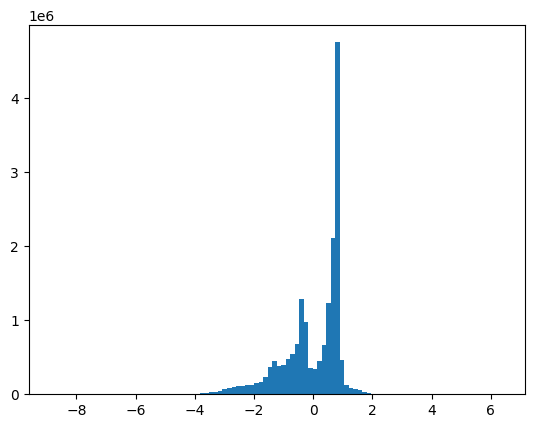

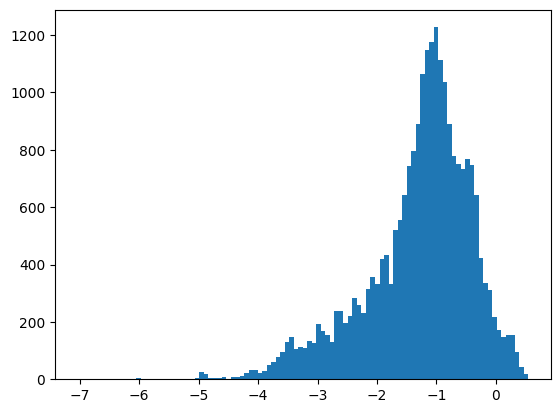

In [7]:
# np.sum(ppe_sim_train['vals'] > y_thresholds)
# test = np.log10(tgt_sim['vals'][0,7204:10804])
# test_finite = test[np.isfinite(test)]
a = 10800
# ytrue = tgt_sim['vals'][:,a+6:a+3606]
# ytrue[~np.isfinite(ytrue)] = np.nan
# plt.hist(ytrue.flatten())
# plt.figure()
# plt.hist(y_all[:,5:65].flatten(), bins=100)
# plt.figure()
# plt.hist(tgt_all[:,5:65].flatten(), bins=100)

plt.hist(y_all[:,a+65:a+3665].flatten(), bins=100)
plt.figure()
plt.hist(tgt_all[:,a+65:a+3665].flatten(), bins=100)

In [8]:
np.nanmean(ppe_sim_train['vals'][0,a+4:a+3604])
np.nanmax(ppe_sim_train['vals'][:,5:65].flatten())
ppe_sim_train['log_vals'][~np.isfinite(ppe_sim_train['log_vals'])]=np.nan

## separate class/reg training

### classifier

In [6]:
proj_name = 'class_try2_stopearly'

tuner_classifier = kt.RandomSearch(
    lambda hp: tu.build_classifier_model(hp, npar, nobs),
    objective='val_accuracy',
    max_trials=20,
    directory='hp_tuning_withclass/separate_models',
    project_name=proj_name
)

stop_early = keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=5)

tuner_classifier.search(x_train, y_train_wpresence,
                          epochs=50,
                          validation_data=(x_val, y_val_wpresence),
                          callbacks=[stop_early])
best_classifier = tuner_classifier.get_best_models(num_models=1)[0]

I0000 00:00:1741366692.220368 3606398 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 10240 MB memory:  -> device: 0, name: NVIDIA A100 80GB PCIe, pci bus id: 0000:e1:00.0, compute capability: 8.0


Reloading Tuner from hp_tuning_withclass/separate_models/class_try2_stopearly/tuner0.json


/home/arthurhu/BOSS_PPE/.venv/lib/python3.10/site-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 14 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


In [7]:
best_hps = tuner_classifier.get_best_hyperparameters(num_trials=1)[0]
print(best_hps.values)

{'num_layers': 3, 'units_0': 256, 'dropout_0': False, 'lr': 7.627145633271187e-05, 'dropout_rate_0': 0.30000000000000004, 'units_1': 128, 'dropout_1': False, 'dropout_rate_1': 0.2, 'units_2': 32, 'dropout_2': False, 'dropout_rate_2': 0.1, 'units_3': 224, 'dropout_3': True, 'dropout_rate_3': 0.30000000000000004}


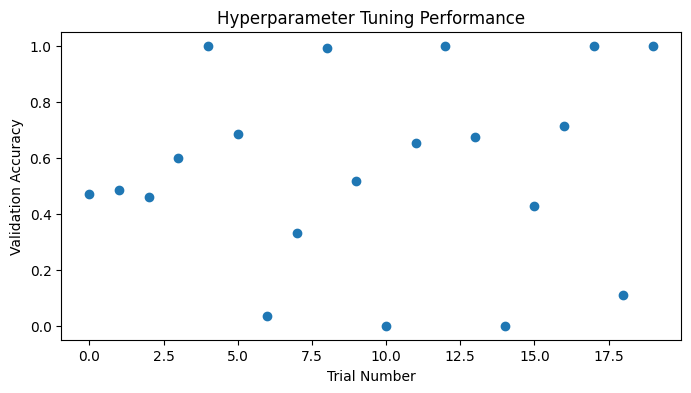

In [8]:
# Extract trial information
trial_ids = []
val_losses = []
for trial_id, trial in tuner_classifier.oracle.trials.items():
    # Ensure there's a recorded validation loss
    val_loss = trial.metrics.get_last_value('val_accuracy')
    if val_loss is not None:
        trial_ids.append(int(trial_id))
        val_losses.append(val_loss)

# Plot validation loss vs. trial number
plt.figure(figsize=(8, 4))
plt.scatter(trial_ids, val_losses)
plt.xlabel("Trial Number")
plt.ylabel("Validation Accuracy")
plt.title("Hyperparameter Tuning Performance")
plt.show()


In [23]:
class PrintDot(keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs):
        if epoch % 100 == 0: print('')
        print('.', end='')

stop_early = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)

history = best_classifier.fit(x_train, y_train_wpresence,
                    epochs=1000,
                    validation_data=(x_val, y_val_wpresence),
                    verbose=0,
                    callbacks=[stop_early, TqdmCallback(verbose=1)])

# ef.clear_gpu_memory()

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

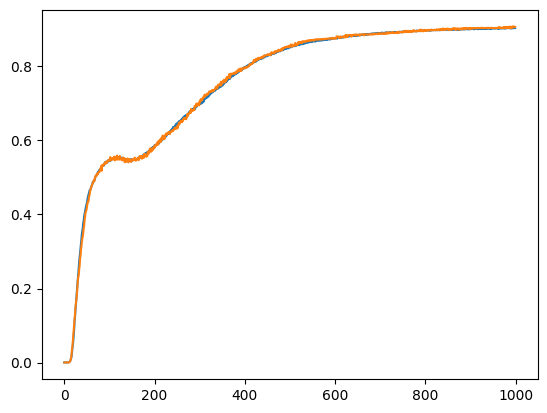

In [28]:
plt.plot(history.epoch, history.history['accuracy'])
plt.plot(history.epoch, history.history['val_accuracy'])

In [38]:
wpresence_mask = y_train_wpresence == 1
print(wpresence_mask)

[[ True  True False ... False False False]
 [ True  True False ... False False False]
 [ True  True False ... False False False]
 ...
 [ True  True False ... False False False]
 [ True  True False ... False False False]
 [ True  True False ... False False False]]


In [39]:
x_train.shape

(8000, 14)

### regressor

## multi-output model

In [15]:
proj_name = 'try36_fullmic_M3069'
tuner = kt.RandomSearch(
    lambda hp: tu.build_classreg_model(hp, npar, nobs),
    objective="val_loss",
    max_trials=100,
    directory='hp_tuning_withclass/multi-output',
    project_name=proj_name,
)


stop_early = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)

tuner.search(
    x_train,
    {'presence': y_train_wpresence, 'water': y_train},
    epochs=50,
    validation_data=(x_val, {'presence': y_val_wpresence, 'water': y_val}),
    callbacks=([stop_early])
)

# Retrieve the best hyperparameters and build the best model:
best_hp = tuner.get_best_hyperparameters(num_trials=1)[0]
best_model = tuner.hypermodel.build(best_hp)



Trial 100 Complete [00h 01m 06s]
val_loss: 1.091335415840149

Best val_loss So Far: 0.3991314172744751
Total elapsed time: 01h 33m 35s


In [16]:
best_model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 14)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, 256)       │      3,840 │ input_layer_1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_4 (Dense)     │ (None, 64)        │     16,448 │ dense_3[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_5 (Dense)     │ (None, 256)       │     16,640 │ dense_4[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_6 (Dense)     │ (None, 256)       │     65,792 │ dense_5[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ presence (Dense)    │ (None, 14465)     │  3,717,505 │ dense_6[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ water (Dense)       │ (None, 14465)     │  3,717,505 │ dense_6[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 7,537,730 (28.75 MB)

 Trainable params: 7,537,730 (28.75 MB)

 Non-trainable params: 0 (0.00 B)

In [17]:
# stop_early = keras.callbacks.EarlyStopping(monitor='val_presence_accuracy', mode='max', patience=2000)

train_dataset = (tf.data.Dataset.from_tensor_slices((x_train, {'presence': y_train_wpresence, 'water': y_train}))
                 .shuffle(buffer_size=len(x_train))
                 .cache()
                 .batch(32)
                 .prefetch(tf.data.AUTOTUNE))

val_dataset = (tf.data.Dataset.from_tensor_slices((x_val, {'presence': y_val_wpresence, 'water': y_val}))
               .cache()
               .batch(32)
               .prefetch(tf.data.AUTOTUNE))

history = best_model.fit(
    train_dataset,
    epochs=15000,
    verbose=0,
    validation_data=val_dataset,
    callbacks=[TqdmCallback(verbose=1)]
)


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

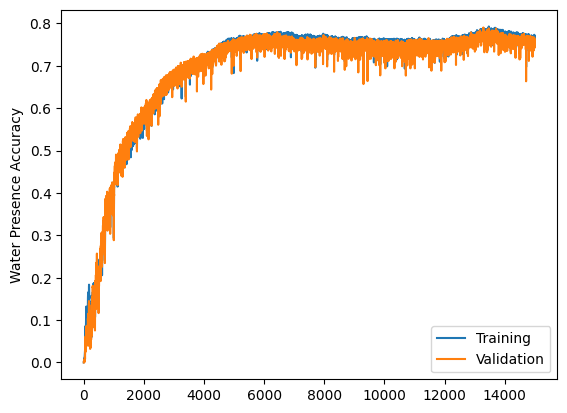

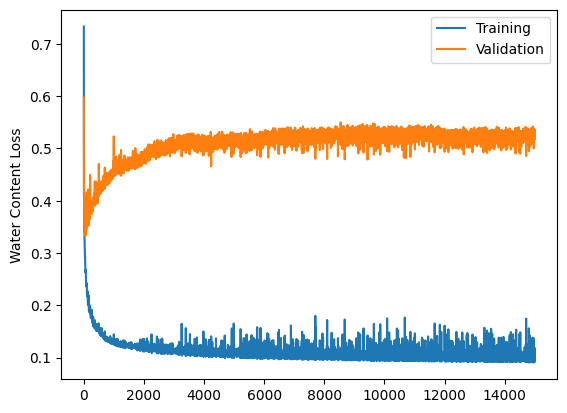

In [18]:
plt.figure()
plt.plot(history.epoch, history.history['presence_accuracy'], label='Training')
plt.plot(history.epoch, history.history['val_presence_accuracy'], label='Validation')
plt.ylabel('Water Presence Accuracy')
plt.legend()

plt.figure()
plt.plot(history.epoch, history.history['water_loss'], label='Training')
plt.plot(history.epoch, history.history['val_water_loss'], label='Validation')
plt.ylabel('Water Content Loss')
plt.legend()

In [19]:
# save model:
best_model.save('models/multioutput_' + proj_name + '.keras')

## validation

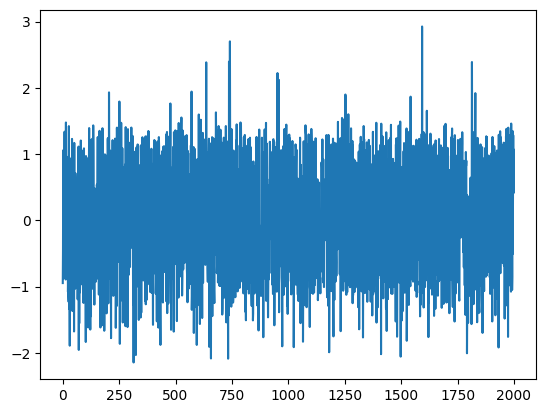

In [42]:
# best_model = tf.keras.models.load_model('models/multioutput_try28_condcoll_fullmom_nopartition_asinh.keras', compile=False)
plt.plot(best_model(x_val)[1][:, 0])
# cc_model(x_val)[1]

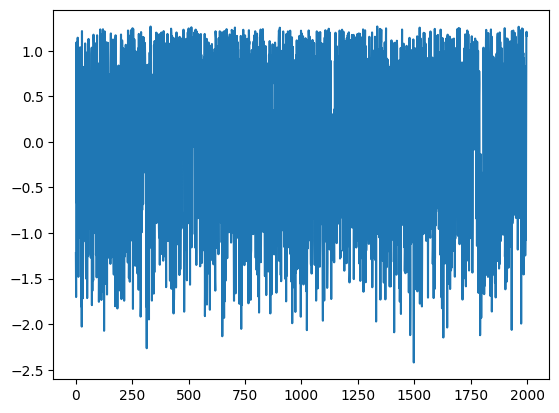

In [43]:
plt.plot(y_val[:,0])

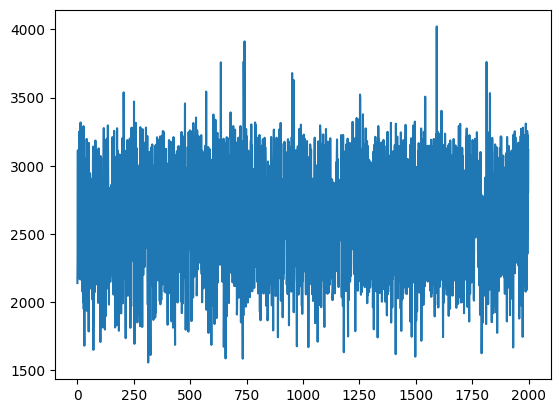

In [44]:
y_pred = standscale.inverse_transform(best_model(x_val)[1].numpy())
# y_pred = model(x_val)
plt.plot(y_pred[:,0])

In [45]:
standscale.inverse_transform(y_train)

array([[2.16994531e+03, 4.29662695e-26, 6.16100940e-41, ...,
                   nan,            nan,            nan],
       [2.19549910e+03, 3.08341198e-26, 6.09891727e-41, ...,
                   nan,            nan,            nan],
       [2.89062355e+03, 3.30391371e-26, 5.67175441e-41, ...,
                   nan,            nan,            nan],
       ...,
       [2.94944698e+03, 4.05458859e-26, 5.91897072e-41, ...,
                   nan,            nan,            nan],
       [3.07151147e+03, 4.19538681e-26, 6.05976930e-41, ...,
                   nan,            nan,            nan],
       [3.07744974e+03, 4.16367147e-26, 6.02805128e-41, ...,
                   nan,            nan,            nan]])

In [46]:
np.mean(y_pred[:, 0]), np.mean(standscale.inverse_transform(y_train)[:, 0])

(2608.5144, 2600.85076300578)

In [47]:
y_pred.shape

(2000, 10803)

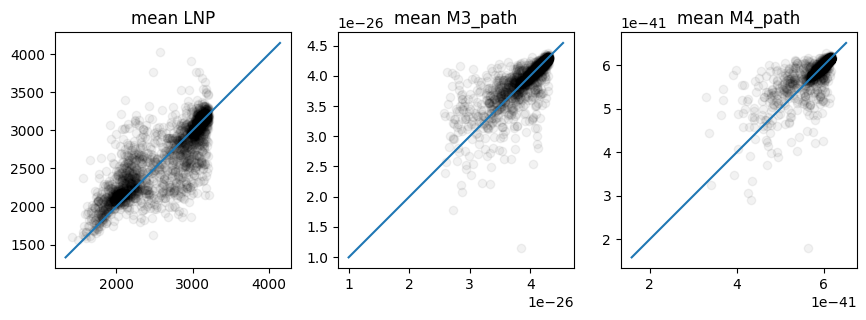

In [48]:
y_pred = standscale.inverse_transform(best_model(x_val)[1].numpy())
# y_pred = standscale.inverse_transform(model(x_val).numpy())
# y_pred = np.exp(standscale.inverse_transform(model(x_val).numpy()))
y_val_lin = standscale.inverse_transform(y_val)
# y_train_lin = np.exp(standscale.inverse_transform(y_train))

fig = plt.figure(figsize=(14,14))
gs = gridspec.GridSpec(1,4)
for i in range(len(eff0)):
    ax = fig.add_subplot(gs[i])
    ax.set_aspect('equal')
    plt.scatter(y_val_lin[:,i], y_pred[:,i], alpha=0.05,c='k')
    # plt.scatter(ppe_sim_valid['vals'][:,i], y_pred[:,i],alpha=0.2,c='k')
    # plt.scatter(y_val[:,i], y_pred[:,i],alpha=0.2,c='k')
    plt.title(ppe_sim_train['var_names'][i])
    ax_min = min(list(ax.get_ylim() + ax.get_xlim()))
    ax_max = max(list(ax.get_ylim() + ax.get_xlim()))
    plt.plot([ax_min, ax_max], [ax_min, ax_max])
    # ax.set_xscale('log')
    # ax.set_yscale('log')
# fig.tight_layout()
# plt.savefig(plot_dir + proj_name + '.png')